# Описание проекта

Данный проект посвящен анализу развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Задача данного исследования — разобраться в причинах и помочь компании выйти в плюс.

В нашем распоряжении есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
* лог сервера с данными об их посещениях,
* выгрузка их покупок за этот период,
* рекламные расходы.

Нам предстоит изучить:
* откуда приходят пользователи и какими устройствами они пользуются,
* сколько стоит привлечение пользователей из различных рекламных каналов;
* сколько денег приносит каждый клиент,
* когда расходы на привлечение клиента окупаются,
* какие факторы мешают привлечению клиентов.

В проекте мы анализируем данные на момент 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

## Загрузка данных и их подготовка к анализу

В этом разделе мы загрузим нужные библиотеки и необходимые для работы датафреймы, а также проведем предобработку данных

### Загрузка и обзор данных
Загрузка библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

Загрузка баз данных

In [2]:
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),
    pd.read_csv('/datasets/orders_info_short.csv'),
    pd.read_csv('/datasets/costs_info_short.csv')
)

Просмотр первых 10 строчек в датафреймах

In [3]:
display(visits.head(10), orders.head(10), costs.head(10))

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
5,90242400005,United States,iPhone,RocketSuperAds,2019-05-01 07:14:52,2019-05-01 08:19:56
6,43958116050,United States,Android,organic,2019-05-01 09:03:21,2019-05-01 10:08:39
7,185365244969,United States,iPhone,organic,2019-05-01 09:37:03,2019-05-01 10:00:43
8,446013509831,United States,iPhone,RocketSuperAds,2019-05-01 10:26:00,2019-05-01 10:59:17
9,100970711362,United States,Mac,TipTop,2019-05-01 04:39:53,2019-05-01 04:57:05


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
5,129100331057,2019-05-01 01:56:28,4.99
6,626807144131,2019-05-01 02:39:21,4.99
7,914062168985,2019-05-01 02:02:18,4.99
8,769669137453,2019-05-01 03:39:47,4.99
9,434198630691,2019-05-01 18:16:50,5.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
5,2019-05-06,FaceBoom,118.8
6,2019-05-07,FaceBoom,101.2
7,2019-05-08,FaceBoom,100.1
8,2019-05-09,FaceBoom,93.5
9,2019-05-10,FaceBoom,104.5


Просмотр общей информации о датафреймах

In [4]:
print(visits.info(), '\n\n')
print(orders.info(), '\n\n')
print(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None


Согласно документации и данным, датафреймы содержат следующие переменные:

Датафрейм `visits`:
* `User Id` — уникальный идентификатор пользователя,
* `Region` — страна пользователя,
* `Device` — тип устройства пользователя,
* `Channel` — идентификатор источника перехода,
* `Session Start` — дата и время начала сессии,
* `Session End` — дата и время окончания сессии.

Датафрейм `orders`:
* `User Id` — уникальный идентификатор пользователя,
* `Event Dt` — дата и время покупки,
* `Revenue` — сумма заказа.

Датафрейм `costs`:
* `Channel` — идентификатор рекламного источника,
* `Dt` — дата проведения рекламной кампании,
* `Costs` — расходы на эту кампанию.


В данных есть следующие проблемы, которые необходимо устранить перед переходом к анализу данных:
* Названия переменных написаны с большой буквы и не по правилам "змеиного" регистра
* Переменные, указывающие на время, имеют тип `object`, а не `datetime`. Идентификационные номера имеют тип `int`, хотя мы не собираемся проводить с ними математических операций, так что лучше сделать их категориальными переменными
* Необходима проверка на наличие дубликатов в данных

### Изменение названий переменных

Приведение к нижнему регистру и заполнение пробелов нижним подчеркиванием

In [5]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
costs.columns = [x.lower().replace(' ', '_') for x in costs.columns.values]

print(visits.columns, '\n\n',
     orders.columns, '\n\n',
     costs.columns)

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object') 

 Index(['user_id', 'event_dt', 'revenue'], dtype='object') 

 Index(['dt', 'channel', 'costs'], dtype='object')


### Изменение типов данных

Преобразование данных о времени в тип `datetime`

In [6]:
dates_to_change = ['session_start', 'session_end']
for date in dates_to_change:
    visits[date] = pd.to_datetime(visits[date])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

Преобразование `user_id` в тип `object`

In [7]:
visits['user_id'] = visits['user_id'].astype(object)
orders['user_id'] = orders['user_id'].astype(object)

Просмотр информации о типах данных в датафреймах

In [8]:
print(visits.info(), '\n\n')
print(orders.info(), '\n\n')
print(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
user_id          309901 non-null object
region           309901 non-null object
device           309901 non-null object
channel          309901 non-null object
session_start    309901 non-null datetime64[ns]
session_end      309901 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(4)
memory usage: 14.2+ MB
None 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
user_id     40212 non-null object
event_dt    40212 non-null datetime64[ns]
revenue     40212 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 942.6+ KB
None 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null datetime64[ns]
channel    1800 non-null object
costs      1800 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory

### Проверка дубликатов

Проверяем количество дубликатов в каждом датафрейме. Дубликаты оказываются только в датафрейме `costs`

In [9]:
print('Число дубликатов в датафрейме "visits":', visits.duplicated().sum(), '\n',
     'Число дубликатов в датафрейме "orders":', orders.duplicated().sum(), '\n',
     'Число дубликатов в датафрейме "costs":', costs.duplicated().sum())

Число дубликатов в датафрейме "visits": 0 
 Число дубликатов в датафрейме "orders": 0 
 Число дубликатов в датафрейме "costs": 0


Удаляем дубликаты из датафрейма `costs`, после еще раз убеждаемся, что в нем не осталось дубликатов

In [10]:
costs = costs.drop_duplicates().reset_index(drop=True)
print('Число дубликатов в датафрейме "costs":', costs.duplicated().sum())

Число дубликатов в датафрейме "costs": 0


### Вывод по разделу

В этом разделе мы провели обзор и предобработку данных:
1. Изменили названия переменных (привели к нижнему и змеиному регистру)
2. Преобразовали данные о времени в тип `datetime`, данные об ID сделали категориальными
3. Удалили дубликаты из таблицы `costs`

## Функции для расчета и анализа LTV, ROI, удержания и конверсии

В этом разделе мы зададим следующие функции:
* Функция для получения пользовательских профилей
* Функция для расчета удержания пользователей
* Функция для расчета конверсии
* Функция для расчета LTV, ROI и CAC
* Функция для сглаживания датафрейма
* Функция для визуализации удержания
* Функция для визуализации конверсии
* Функция для визуализации LTV, ROI и CAC

### Функция для получения пользовательских профилей

In [11]:
def get_profiles(visits, orders, ad_costs):
    # находим параметры первых посещений:
    # сортируем сессии по id пользователя и дате для того, чтобы работал first
    # находим первые значения для параметров пользователя - будем считать их основными 
    profiles = (
        visits.sort_values(by = ['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start' : 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first'
            }
        )
        .rename(columns = {'session_start' : 'first_ts'})
        .reset_index()  # вернем все данные из индекса в колонки
    )
    
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date.astype('datetime64')
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

### Функция для расчета удержания

In [12]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчета конверсии

In [13]:
def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчета LTV и ROI

In [14]:
def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функция для сглаживания графиков

In [15]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

### Функция для визуализации удержания

In [16]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

### Функция для визуализации конверсии

In [17]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Функция для визуализации LTV и ROI

In [18]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Момент и горизонт анализа данных

In [19]:
observation_date = pd.to_datetime('2019-11-01')
horizon_days = 14

### Вывод по разделу

В этом разделе мы задали функции для расчета метрик и визуализации этих расчетов, а также обозначили момент и горизонт анализа.

## Исследовательский анализ данных

В этом разделе мы проведем исследовательский анализ данных и рассмотрим следующие пункты:
* Опредение минимальной и максимальной даты привлечения пользователей
* Определение стран, откуда приходят посетители, определение стран, которые дают больше всего платящих пользователей
* Определение устройств, которыми пользуются посетители, в том числе платящие
* Определение каналов, по которым шло привлечение пользователей, в том числе платящих

### Получение пользовательских профилей, определение минимальной и максимальной дат привлечения пользователей

Получаем пользовательские профили с помощью функции, заданной в предыдущем разделе, а также профили платящих пользователей. Просматриваем полученный датафрейм, который содержит информацию об ID пользователя, первом посещении приложения, канале привлечения, устройстве, стране пользователя, является / не явяется пользователь платящим, стоимости привлечения пользователя.

In [20]:
profiles = get_profiles(visits, orders, costs)
payers = profiles.query('payer == True')
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Выводим самую раннюю и самую позднюю даты привлечения пользователей. Самая ранняя дата - 1 мая 2019 года, а самая поздняя - 27 октября 2019 года, что значит, что в нашем распоряжении данные за ~ 6 месяцев

In [21]:
print('Минимальная дата привлечения пользователей:', profiles['dt'].min(), '\n',
     'Максимальная дата привлечения пользователей:', profiles['dt'].max())

Минимальная дата привлечения пользователей: 2019-05-01 00:00:00 
 Максимальная дата привлечения пользователей: 2019-10-27 00:00:00


### Определение стран, откуда приходят пользователи

Зададим функции для сводной таблицы с подсчетом всех пользователей и доли платящих пользователей по выбранному признаку (по странам, устройствам, каналам привлечения), для визуализации полученной сводной таблицы.

In [22]:
def pivot_table(index_variable):
    all_users_pivot = profiles.pivot_table(index=index_variable,
                                           values='user_id', aggfunc='count') # подсчет всех пользователей по выбранному признаку
    all_users_pivot.columns = ['Все пользователи'] # переименование столбцов
    payers_pivot = payers.pivot_table(index=index_variable, values='payer',
                                      aggfunc='count') # подсчет платящих пользователей по выбранному признаку
    payers_pivot.columns = ['Платящие пользователи'] # переименование столбцов
    all_users_pivot['Доля платящих пользователей, в %'] = round((payers_pivot['Платящие пользователи'] / all_users_pivot['Все пользователи'])*100, 2) # нахождение доли платящих пользователей от всех
    return all_users_pivot


def pivot_visualization(pivot_table_final):
    plt.figure(figsize=(20, 20)) # определение размера подложки
    ax1 = plt.subplot(2, 2, 1) # выбор места для первого графика
    pivot_table_final[['Все пользователи']].sort_values(by='Все пользователи').plot(kind='bar', ax=ax1) # отрисовка графика
    plt.title('Распределение пользователей по странам') # название графика
    plt.xlabel('Страны') # название оси X
    plt.ylabel('Количество пользователей') # название оси Y


    ax2 = plt.subplot(2, 2, 2)
    pivot_table_final[['Доля платящих пользователей, в %']].sort_values(by='Доля платящих пользователей, в %').plot(kind='bar', ax=ax2, ylim=(0, 100))
    plt.title('Распределение платящих пользователей по странам')
    plt.xlabel('Страны')
    plt.show()

Выведем полученные сводную таблицу и столбчатую диаграмму. Как мы видим, доля платящих пользователей во всех странах не превышает 7 %. Больше всего платящих пользователей из США.

,Все пользователи,"Доля платящих пользователей, в %"
region,,
France,17450,3.80
Germany,14981,4.11
UK,17575,3.98
United States,100002,6.90


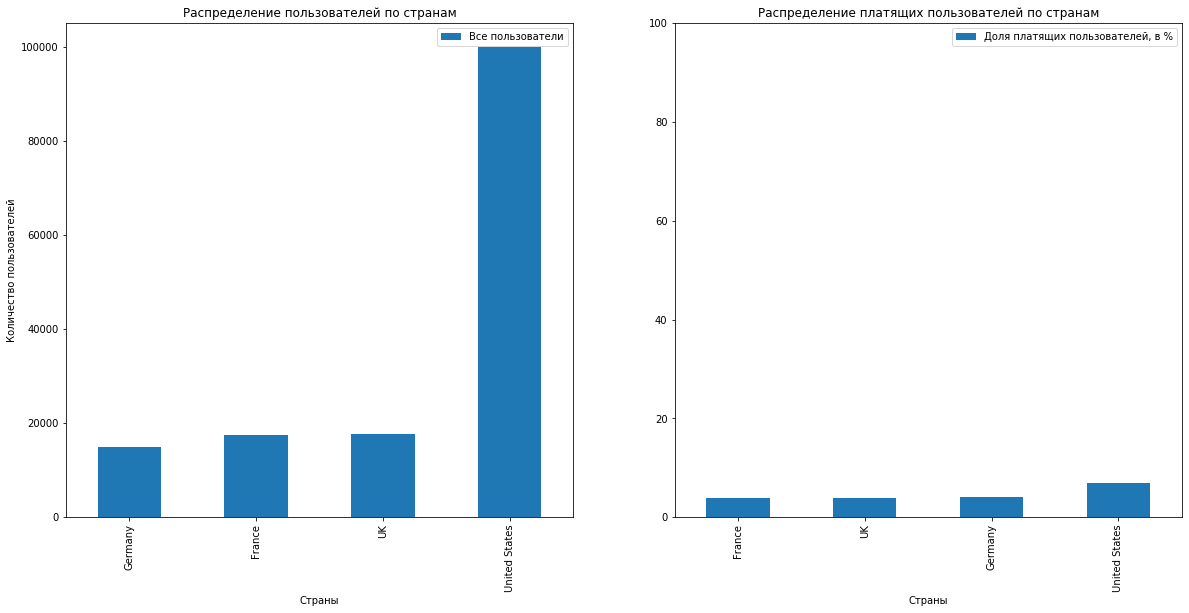

In [23]:
pivot_countries = pivot_table('region')
display(pivot_countries)
pivot_visualization(pivot_countries)

### Определение устройств, которыми пользуются пользователи

При рассмотрении распределения платящих и всех пользователей по устройствам мы можем видеть примерно такую же картину, как при рассмотрении стран: платящих пользователей не более 7 % при использовании каждого устройства. Больше всего пользователей с IPhone, но при этом доля платящих пользователей Mac выше всех.

,Все пользователи,"Доля платящих пользователей, в %"
device,,
Android,35032,5.85
Mac,30042,6.36
PC,30455,5.05
iPhone,54479,6.21


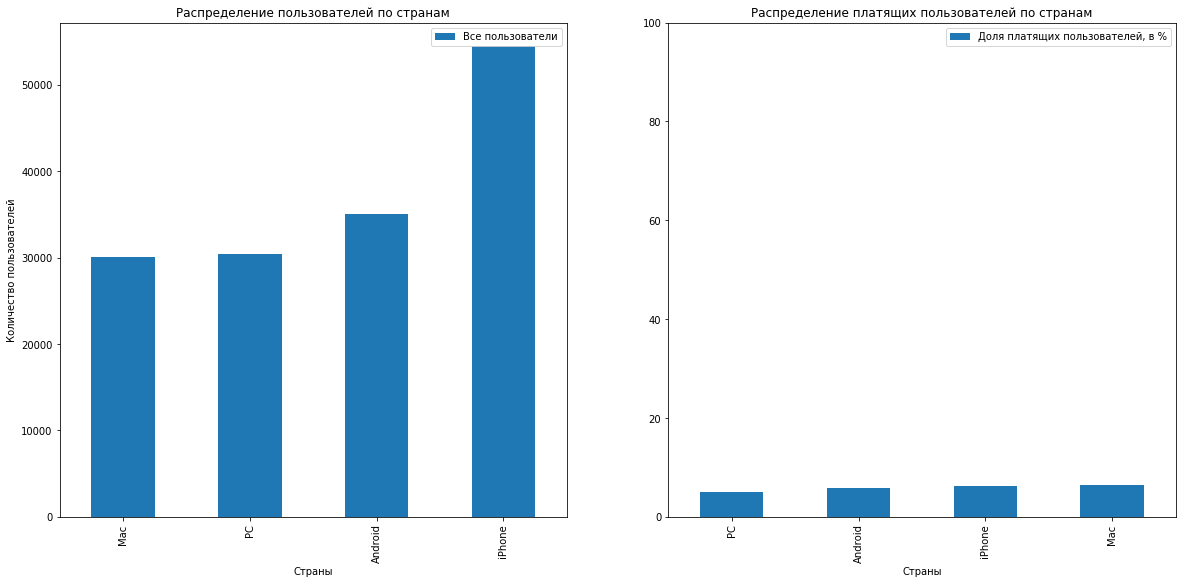

In [24]:
pivot_devices = pivot_table('device')
display(pivot_devices)
pivot_visualization(pivot_devices)

### Определение каналов, откуда пришли пользователи

Рассмотрим распределение пользователей и платящих пользователей по каналам привлечения. Доля платящих пользователей здесь сильнее различается: выделяются лидеры (AdNonSense, FaceBoom, lambdaMediaAds) c процентом платящих пользователей более 10 %. Также стоит отметить, что органических пользователей больше всех, однако доля платящих пользователей из этого канала меньше всех.

,Все пользователи,"Доля платящих пользователей, в %"
channel,,
AdNonSense,3880,11.34
FaceBoom,29144,12.20
LeapBob,8553,3.06
MediaTornado,4364,3.57
OppleCreativeMedia,8605,2.71
RocketSuperAds,4448,7.91
TipTop,19561,9.60
WahooNetBanner,8553,5.30
YRabbit,4312,3.83


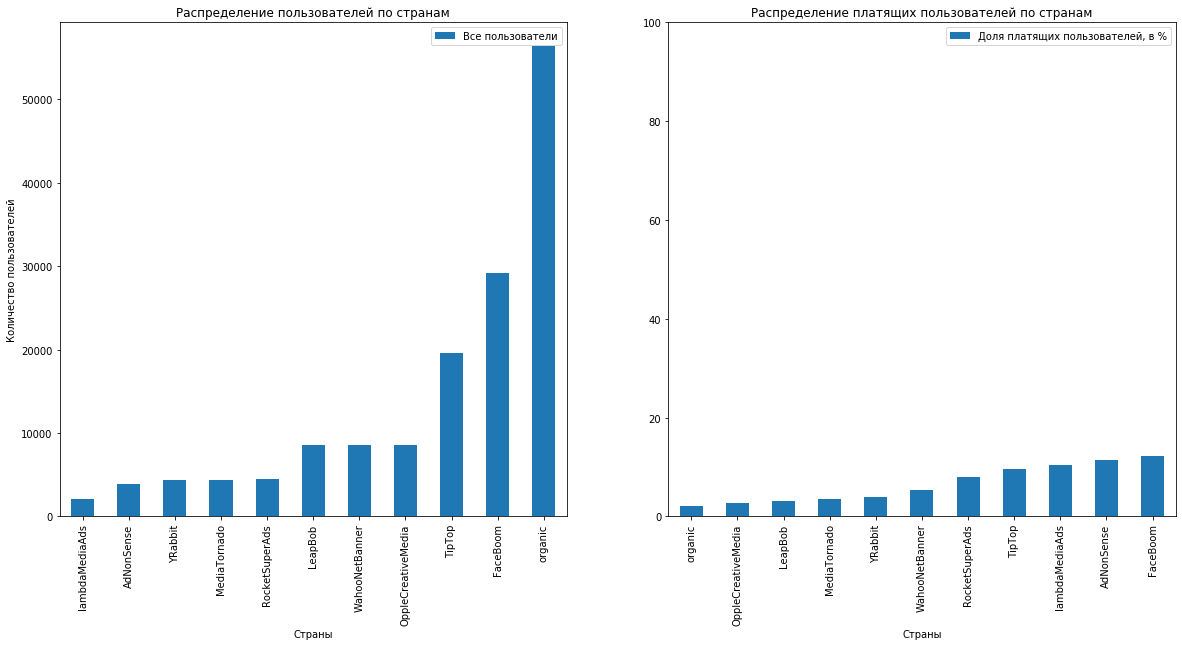

In [25]:
pivot_channels = pivot_table('channel')
display(pivot_channels)
pivot_visualization(pivot_channels)

### Вывод по разделу

В этом разделе мы получили с помощью функции пользовательские профили, определили, что в профилях содержатся данные за ~ 6 месяцев с мая 2019 до октября 2019, а также рассмотрели распределение всех пользователей и платящих пользователей по странам, устройствам, каналам привлечения (во всех разрезах платящих пользователей намного меньше, чем всех, так что стоит отдельно проверить конверсию пользователей в платящих).

## Маркетинг

В этом разделе мы расмотрим суммарные расходы на маркетинг, а также среднюю стоимость привлечения одного клиента (CAC).

### Суммарные расходы на маркетинг

Рассмотрим суммарные расходы на маркетинг. Всего за полгода создатели приложения потратили 105 497.3 ед. на маркетинг.

In [26]:
print('Суммарные траты на маркетинг:', round(costs['costs'].sum(), 2))

Суммарные траты на маркетинг: 105497.3


Рассмотрим распределение трат по каналам привлечения пользователей. Как мы видим на графике, больше всего создатели приложения тратят на источники TipTop и FaceBoom.

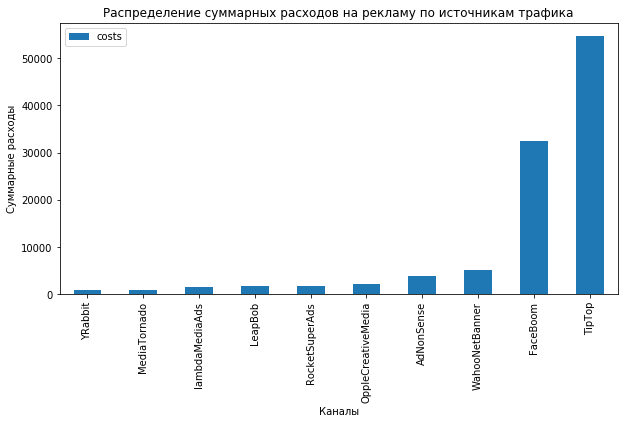

In [27]:
costs.pivot_table(index='channel', values='costs', aggfunc='sum').sort_values(by='costs').plot(kind='bar',
                                                                 figsize=(10,5))
plt.title('Распределение суммарных расходов на рекламу по источникам трафика')
plt.xlabel('Каналы')
plt.ylabel('Суммарные расходы')
plt.show()

Также посмотрим на динамику суммарных трат на разные источники. Траты на большинство источников остаются довольно стабильными на протяжении полугода, а траты на TipTop и FaceBoom увеличиваются на протяжении всего времени: траты на TipTop растут более резко, траты на FaceBoom - менее активно.

Text(0, 0.5, 'Суммарные расходы')

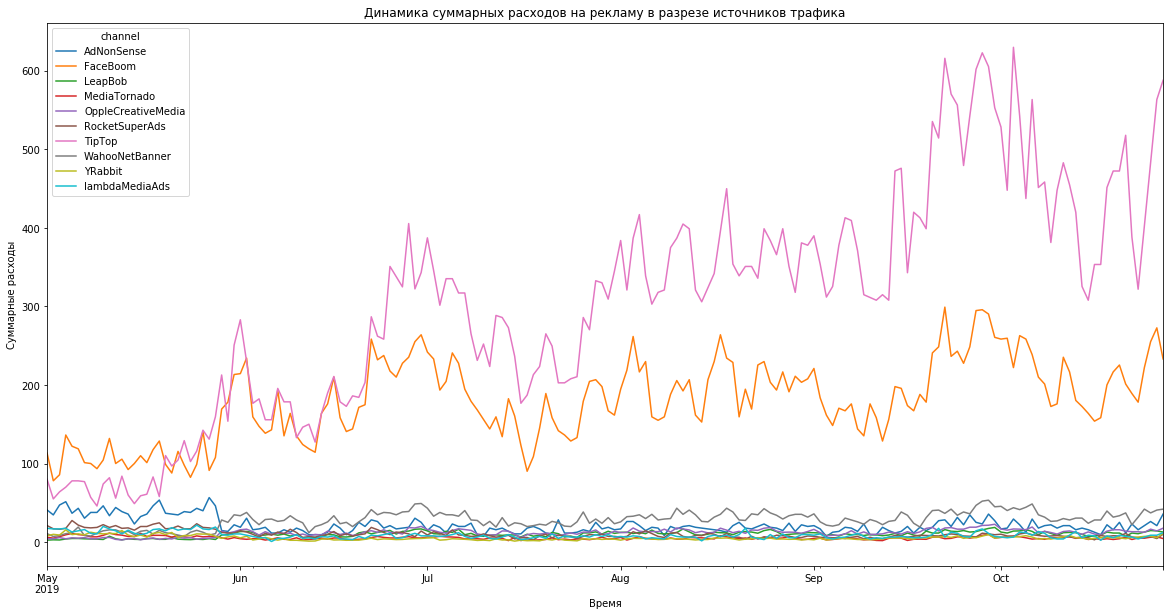

In [28]:
costs.pivot_table(index='dt', values='costs', columns='channel', aggfunc='sum').plot(style='-',
                                                                 figsize=(20,10))
plt.title('Динамика суммарных расходов на рекламу в разрезе источников трафика')
plt.xlabel('Время')
plt.ylabel('Суммарные расходы')

### Расчет стоимости привлечения клиента (CAC)

Теперь рассмотрим стоимость привлечения одного пользователя и рассчитаем метрику CAC. 

Перед расчетом CAC убираем из профилей пользователей, пришедших по каналу `organic`, так как их привлечение равно 0 и будет смещать среднее вниз. Кроме того, удаление органических пользователей позволит не нагружать график изменений CAC по каналам.

Сначала рассчитываем CAC в целом, и, как мы видим, средняя стоимость привлечения одного пользователя увеличивается на протяжении всего периода примерно в 2 раза (в мае ~0.7 ед., в конце октября ~1.4 ед.). Далее стоит проверить, увеличивается ли общая CAC за счет определенных каналов.

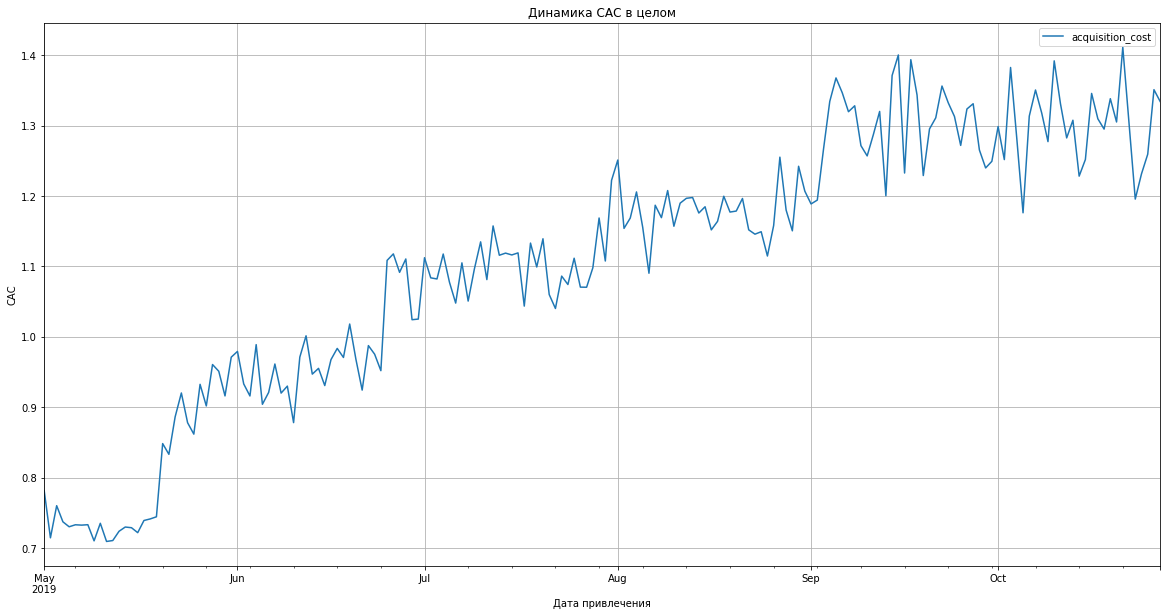

In [29]:
profiles_without_organic = profiles.query('channel != "organic"')
profiles_without_organic.pivot_table(index='dt',
                                     values='acquisition_cost',
                                     aggfunc='mean').plot(grid=True,
                                                          figsize=(20, 10))

plt.ylabel('CAC')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС в целом')
plt.show()

Рассмотрим CAC в разрезе источников. Как мы видим, линии, все каналы на протяжении полугода имеют имеют примерно одинаковую стоимость привлечения пользователя, она колеблется, однако в целом не особо сильно растет.

От всех каналов отличается только TipTop, CAC у которого постоянно растет на протяжении всего времени (стоимость привлечения одного пользователя в мае равна ~1 ед., в конце октября - ~3.5 ед.). Возможно, общая CAC растет за счет роста CAC у этого канала.

Также стоит заметить, что суммарные траты на канал FaceBoom росли, однако, в отличие от TipTop, у этого канала не растет CAC. Возможно это связано с эффективностью канала: он приводит большое число пользователей, и поэтому траты на каждого нового пользователя остаются стабильными.

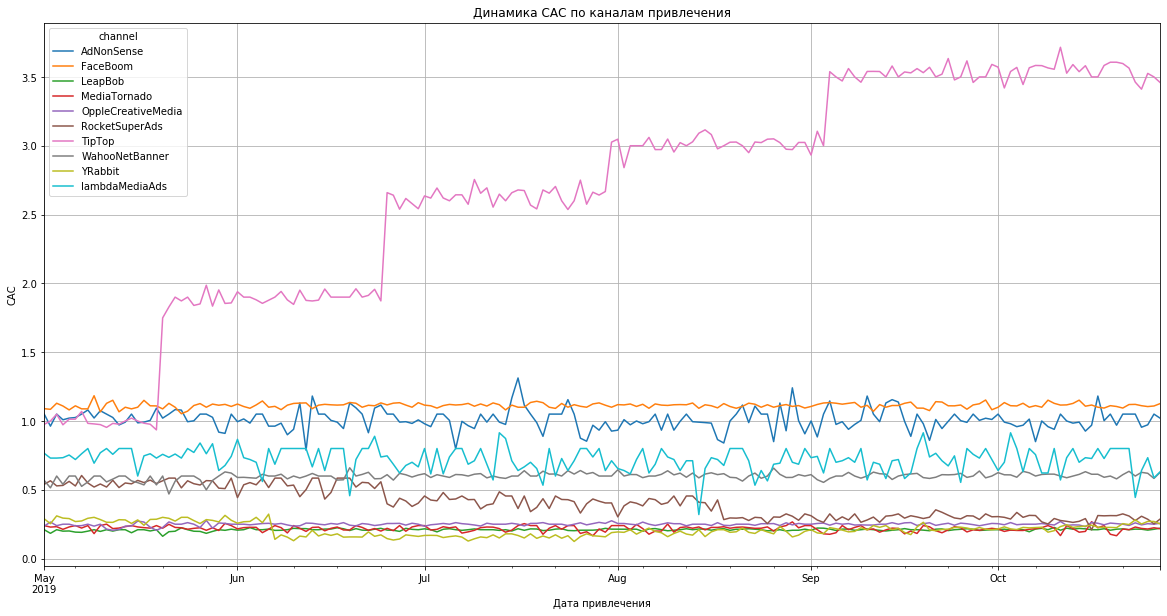

In [30]:
profiles_without_organic.pivot_table(index='dt', columns='channel',
                                                   values='acquisition_cost',
                                                   aggfunc='mean').plot(grid=True,
                                                                        figsize=(20, 10))
plt.ylabel('CAC')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

### Вывод по разделу

Анализ трат на маркетинг позволил прийти к следующим промежуточным выводам:
* Больше всего трат совершается на каналы TipTop и FaceBoom. При этом на протяжении всего периода наблюдения траты на них, в отличие от других каналов, растут
* На протяжении всего периода наблюдения можно наблюдать увеличение стоимости привлечения одного пользователя, которое происходит за счет увеличения CAC у канала TipTop. Стоимость привлечения одного пользователя у источника FaceBoom не растет, что может говорить об эффективности канала.

## Оценка окупаемости рекламы для привлечения пользователей

В этом разделе мы оценим общую окупаемость рекламы и окупаемость по странам, устройствам, каналам привлечения. Кроме того, рассмотрим возможные причины проблем с окупаемостью с помощью конверсии и удержания пользователей.

### Общая окупаемость рекламы

Оценить общую окупаемость рекламы можно с помощью расчета метрик LTV (Lifetime Value) и ROI (Return On Investment) и их визуализации.

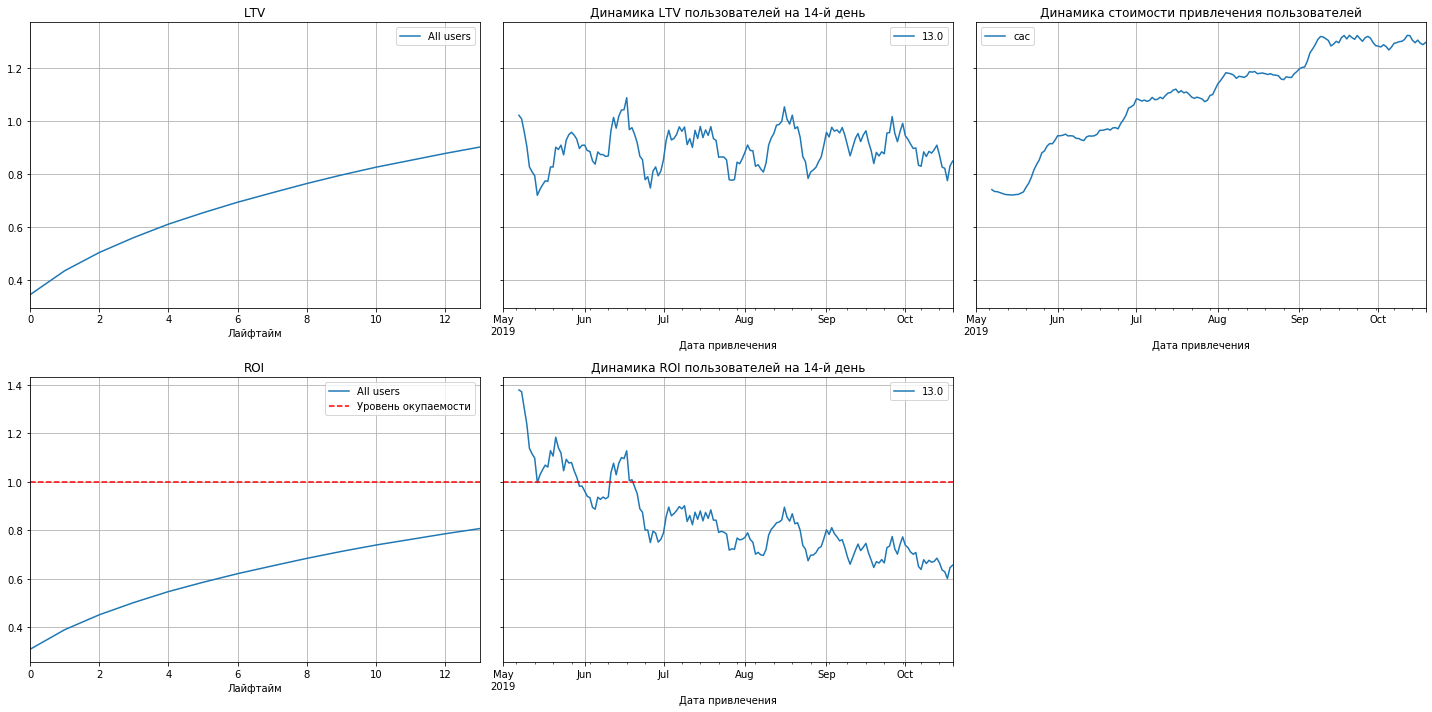

In [31]:
lvt_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
   profiles_without_organic, orders, observation_date, horizon_days)
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days)

По графикам можно сделать следующие выводы:
* Динамика LTV на 14 день достаточно стабильна. Возможно, ее колебания связаны с сезонным фактором, так как можно наблюдать повышение LTV в середине каждого месяца. Таким образом, можно сделать вывод, что качество пользователей не ухудшается
* Затраты на рекламу растут: CAC увеличивается на протяжении всего периода наблюдения
* Реклама не окупается. ROI в конце второй недели не достигает порога окупаемости
* По динамике ROI на 14 день можно увидеть, что реклама перестала окупаться в конце июня: все последующие месяцы ROI ниже порога окупаемости

Чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству посещения.

### Окупаемость рекламы с разбивкой по устройствам

Подсчитываем LTV и ROI с разбивкой по устройствам посещения.

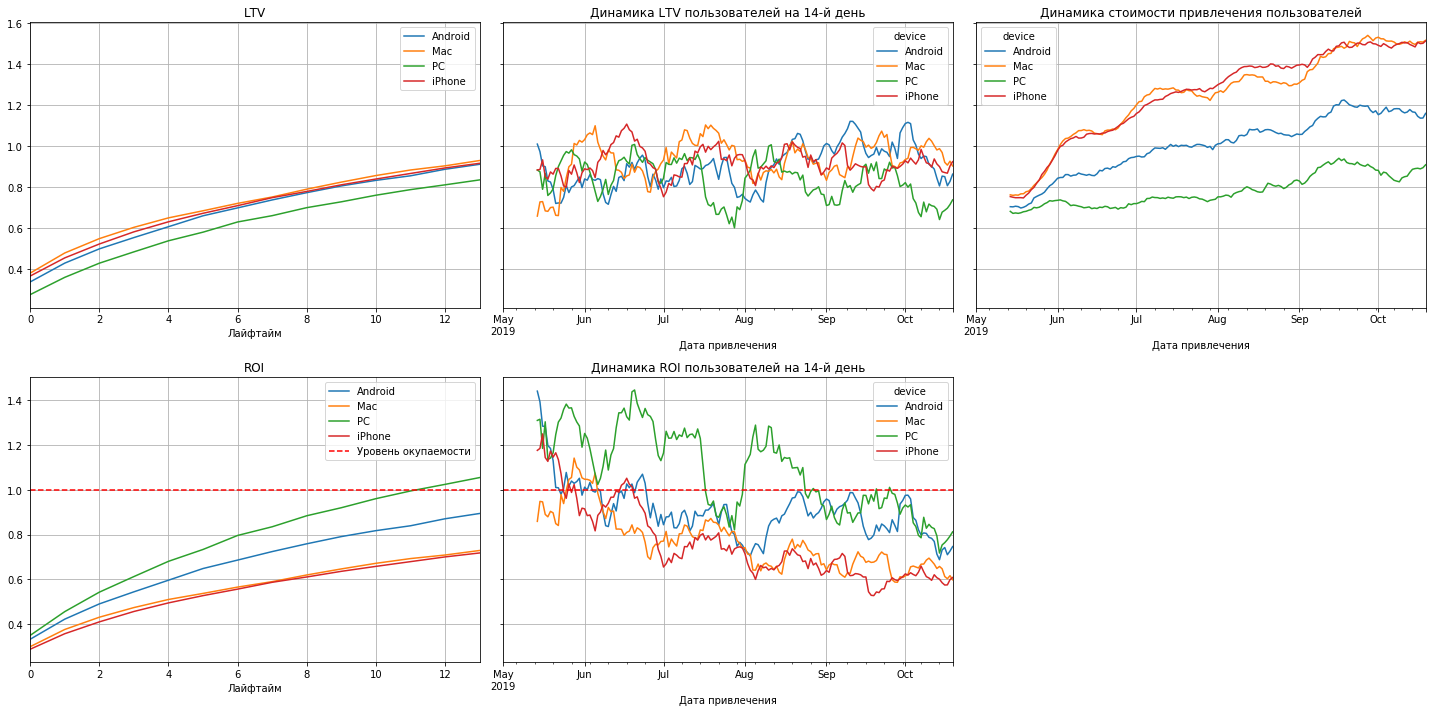

In [33]:
lvt_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
   profiles_without_organic, orders, observation_date, horizon_days, dimensions=['device'])
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days, window=14)

По полученным графикам можно сделать следующие выводы:
* Динамика LTV также остается достаточно стабильной: качество пользователей на всех устройствах не уменьшается
* Траты на рекламу на всех устройствах растут на протяжении всего периода наблюдения, правда на технику Apple (Mac и IPhone) увеличиваются сильнее
* При увеличении трат на рекламу на устройства Apple, она не окупается на 14 день. Также не окупается реклама на устройствах Android. Порога окупаемости достигает только PC примерно на 12 день.
* Окупаемость рекламы снижается на всех устройствах на протяжении всего времени наблюдения, и к концу октября она ниже порога окупаемости на всех устройствах.

Далее при подсчете конверсии и удержания пользователей стоит отдельное внимание обратить на пользователей с устройствами Mac, IPhone и Android.

### Окупаемость рекламы с разбивкой по странам

Подсчитываем LTV и ROI с разбивкой по странам.

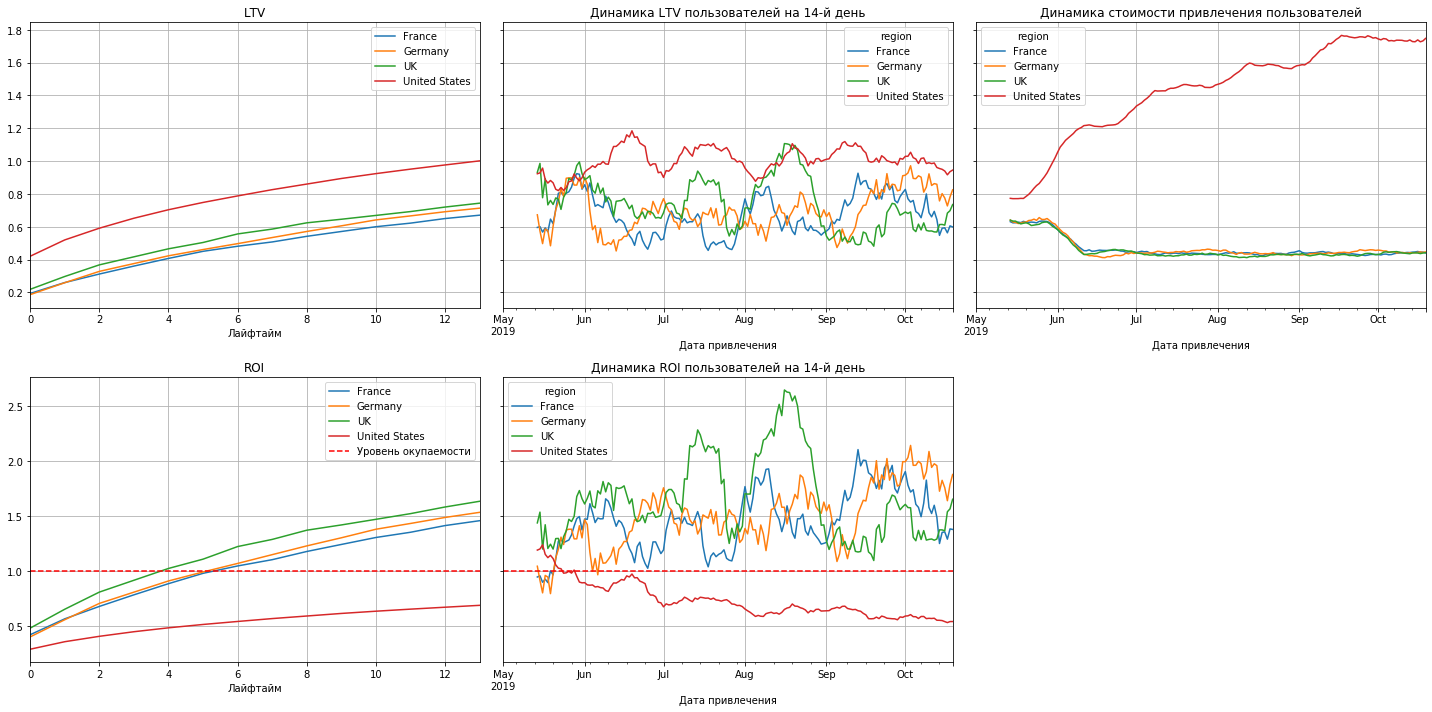

In [34]:
lvt_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
   profiles_without_organic, orders, observation_date, horizon_days, dimensions=['region'])
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days, window=14)

По полученным графикам можно сделать следующие выводы:
* Качество пользователей (динамика LTV) не ухудшается
* Растет стоимость привлечения пользователя из США. Для других пользователей стоимость остается стабильной
* Несмотря на увеличение стоимости привлечения, реклама для пользователей из США не окупается с середины мая

Далее при подсчете конверсии и удержания пользователей стоит отдельное внимание обратить на пользователей из США.

### Окупаемость рекламы с разбивкой по рекламным каналам

Подсчитываем LTV и ROI с разбивкой по каналам привлечения. До применения функции удаляем органических пользователей, так как их привлечение равно 0 и может нагружать график лишней информацией.

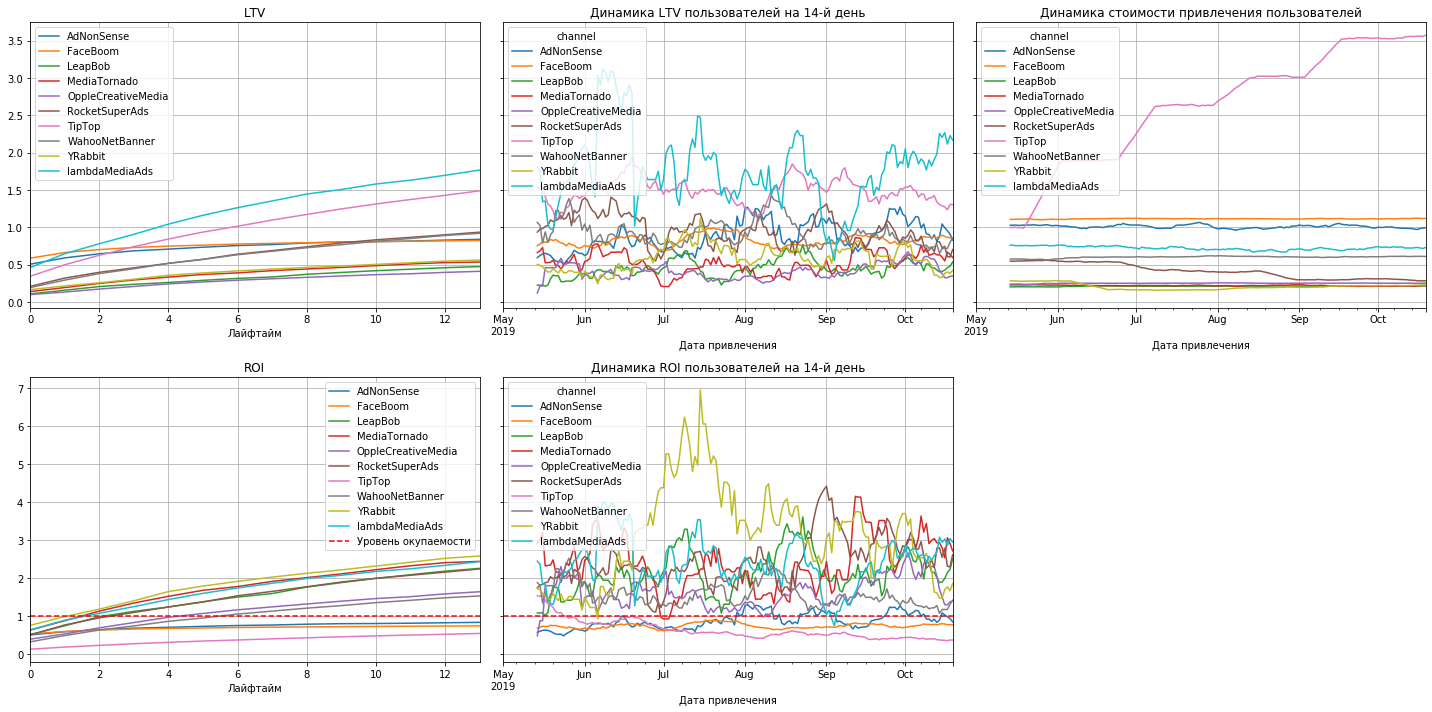

In [35]:
lvt_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles_without_organic, orders, observation_date, horizon_days, dimensions=['channel'])
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days, window=14)

По полученным графикам можно сделать следующие выводы:
* Качество пользователей (динамика LTV) не ухудшается
* Стоимость привлечения клиентов по каналу TipTop растет на протяжении всего периода наблюдения, стоимость по другим каналам остается стабильной
* Не окупаются каналы AdNonSense, FaceBoom, TipTop. По результатам 4 раздела нашего исследования, FaceBoom, TipTop - это каналы, на которые приложение тратит больше всего бюджета, и они при этом не окупаются

Далее при подсчете конверсии и удержания пользователей стоит отдельное внимание обратить на пользователей, пришедших по каналам dNonSense, FaceBoom, TipTop.

### Удержание по устройствам


Подсчитаем и визуализируем удержание по устройствам.

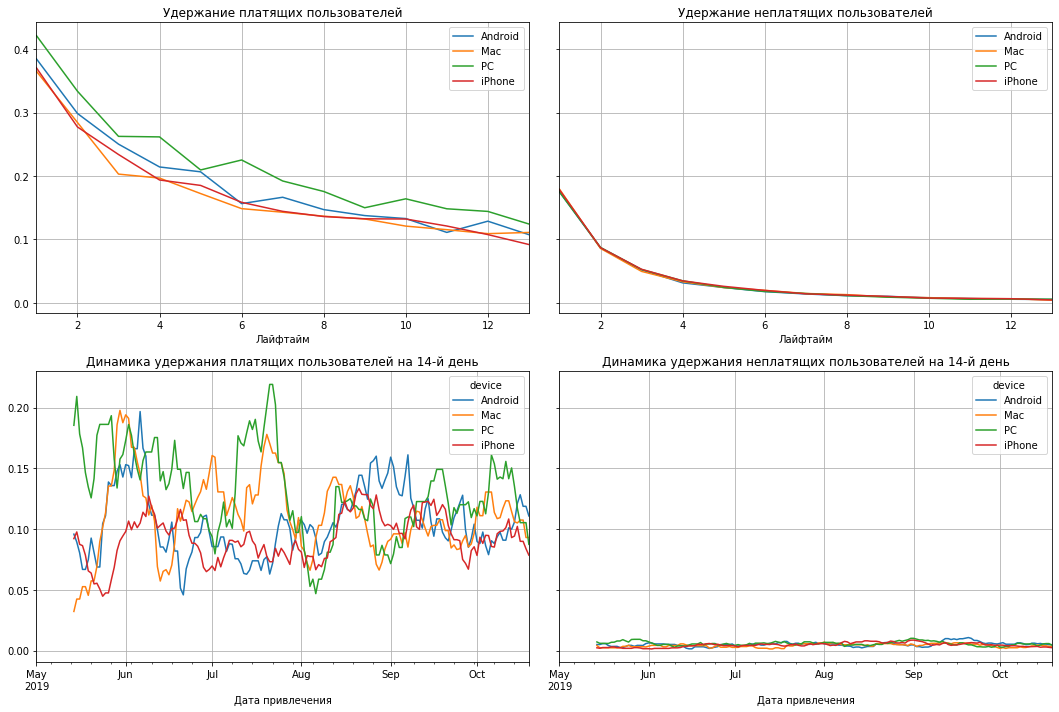

In [36]:
retention_raw, retention_grouped, retention_in_time = get_retention(
    profiles_without_organic, visits, observation_date, horizon_days, dimensions=['device'])

plot_retention(retention_grouped, retention_in_time, horizon_days, window=14)

По полученным графикам нельзя сказать, что удержание пользователей устройств Apple (реклама на которых не окупается) сильно ниже удержания пользователей других устройств. Значит можно сделать вывод, что проблема не окупаемости не в удержании пользователей.

### Удержание по странам

Подсчитаем и визуализируем удержание по странам.

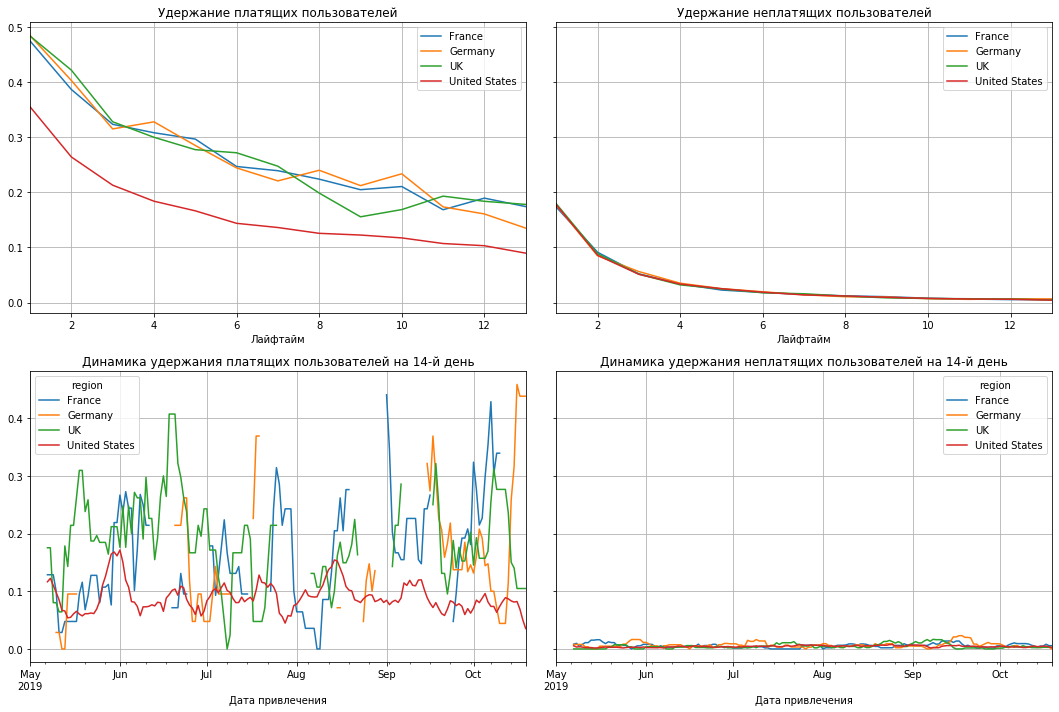

In [37]:
retention_raw, retention_grouped, retention_in_time = get_retention(
    profiles_without_organic, visits, observation_date, horizon_days, dimensions=['region'])

plot_retention(retention_grouped, retention_in_time, horizon_days, window=7)

По графикам можно сделать вывод, что удержание пользователей из США ниже, чем пользователей других стран. Таким образом, пользователи из США плохо удерживаются.

### Удержание по рекламным каналам

Подсчитаем и визуализируем удержание по каналам привлечения.

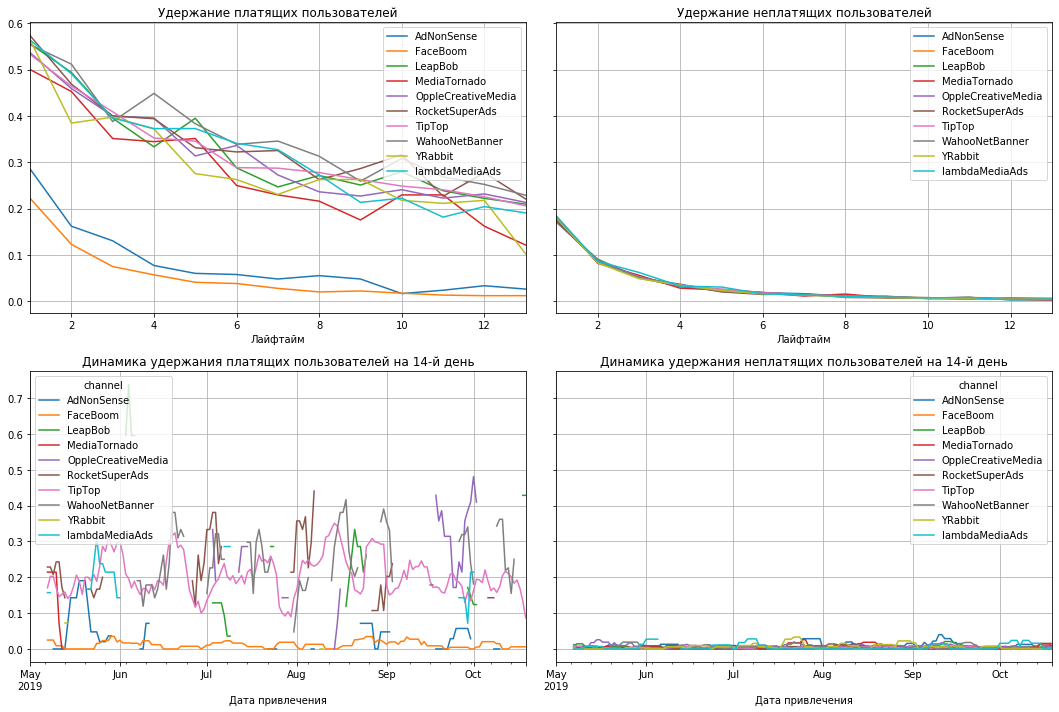

In [38]:
retention_raw, retention_grouped, retention_in_time = get_retention(
    profiles_without_organic, visits, observation_date, horizon_days, dimensions=['channel'])

plot_retention(retention_grouped, retention_in_time, horizon_days, window=7)

По полученным графикам можно сделать вывод, что удержание пользователей, привлеченных по каналам AdNonSense и FaceBoom, ниже, чем пользователей, привлеченных с других каналов. Пользователи с канала TipTop удерживаются достаточно хорошо, значит проблема с их окупаемостью не в удержании.

### Конверсия по устройствам

Подсчитаем и визуализируем конверсию по устройствам.

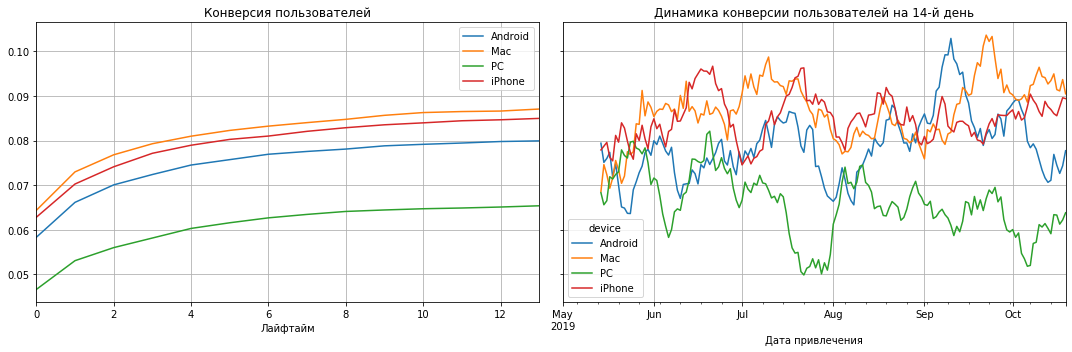

In [39]:
conversion_raw, conversion_grouped, conversion_in_time = get_conversion(
    profiles_without_organic, orders, observation_date, horizon_days, dimensions=['device'])
plot_conversion(conversion_grouped, conversion_in_time, horizon_days, window=14)

По полученным графикам можно сделать вывод, что конверсия пользователей с техникой Apple выше, чем с другими устройствами. Значит, проблема с отсутствием окупаемости рекламы для пользователей с устройствами Mac и IPhone не в удержании и не в конверсии. Построим график средней стоимости привлечения по устройствам, который показывает, что на протяжении всего периода стоимость привлечения пользователей с Mac и IPhone увеличивается активнее, чем стоимость для пользователей с другими устройствами. Таким образом, можно сделать вывод, что причина неокупаемости для Mac и IPhone - слишком высокая стоимость привлечения.

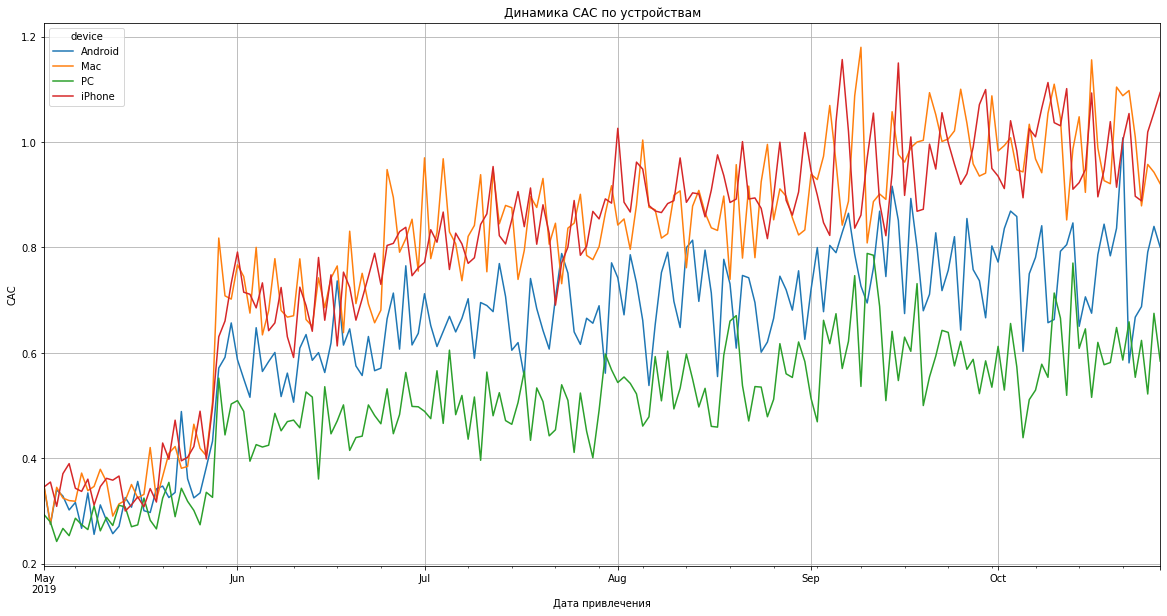

In [40]:
profiles.pivot_table(index='dt', columns='device',
                     values='acquisition_cost',
                     aggfunc='mean').plot(grid=True, figsize=(20, 10))
plt.ylabel('CAC')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по устройствам')
plt.show()

### Конверсия по странам

Подсчитаем и визуализируем конверсию по странам.

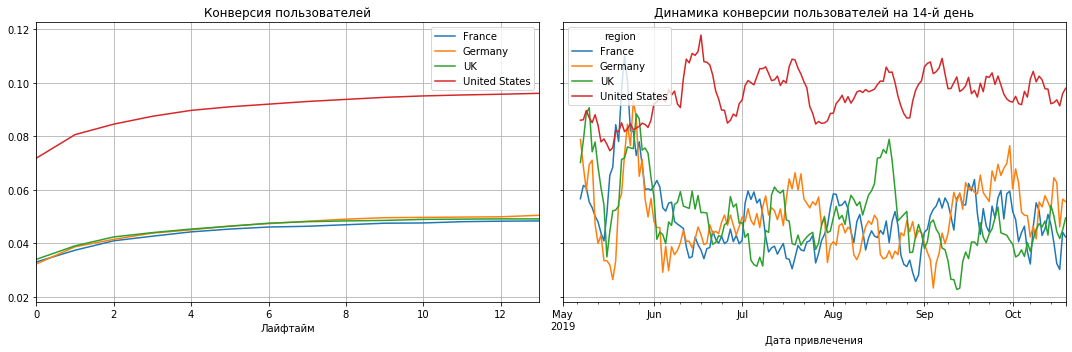

In [41]:
conversion_raw, conversion_grouped, conversion_in_time = get_conversion(
    profiles_without_organic, orders, observation_date, horizon_days, dimensions=['region'])
plot_conversion(conversion_grouped, conversion_in_time, horizon_days, window=7)

Полученные графики показывают, что пользователи из США имеют большую конверсию, чем пользователи из других стран. Учитывая тот факт, что удержание у пользователей из США ниже всех групп, можно сделать вывод, что они лучше всего делают первую покупку, но затем не возвращаются за повторными покупками.

### Конверсия по каналам привлечения

Подсчитаем и визуализируем конверсию по каналам привлечения.

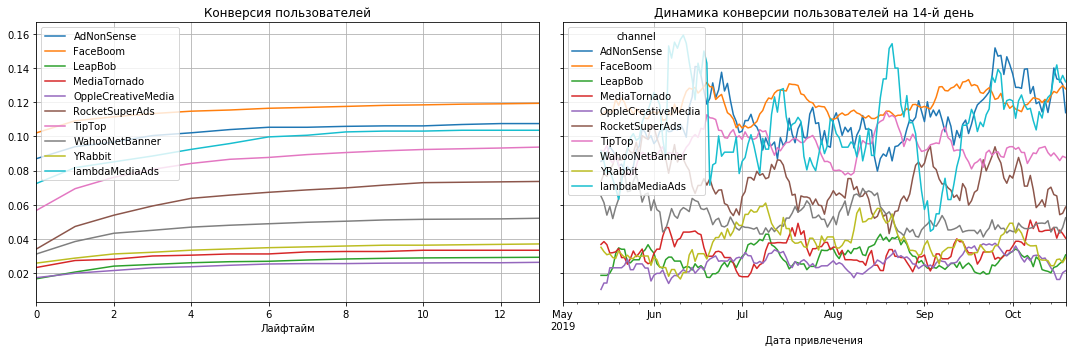

In [42]:
conversion_raw, conversion_grouped, conversion_in_time = get_conversion(
    profiles_without_organic, orders, observation_date, horizon_days, dimensions=['channel'])
plot_conversion(conversion_grouped, conversion_in_time, horizon_days, window=14)

Здесь мы видим аналогичную картину, что при визуализации конверсии по странам: пользователи, привлеченные по каналам AdNonSense и FaceBoom имеют большую конверсию, чем пользователи из других каналов. Учитывая тот факт, что удержание у пользователей из каналов AdNonSense и FaceBoom ниже всех групп, можно сделать вывод, что они лучше всего делают первую покупку, но затем не возвращаются за повторными покупками.

Также стоит отметить, что конверсия пользователей из канала TipTop не особо отличается от других каналов, а значит причины отсутствия окупаемости рекламы из этого канала заключается в слишком высокой цене привлечения.

## Общие выводы

В этом проекте мы изучили окупаемость рекламы для приложения в целом и для пользователей с разными устройствами, из разных стран, из разных каналов привлечения. Основные выводы исследования:
- Затраты на рекламу не окупаются, поэтому компания терпит убытки
- Не окупаются затраты на рекламу для пользователей техники Apple (Mac и IPhone) и Android, несмотря на то, что этих пользователей наилучшая конверсия и неплохое удержание. Причина отсутствия окупаемости для пользователей этих устройств в стоимости привлечения: для них CAC увеличивается на протяжении всего периода наблюдения
- Не окупается реклама для пользователей из США, при этом стоимость их привлечения растет наиболее активно. Пользователи из США имеют наибольшую конверсию, однако наименьшее удержание, а значит, они не возвращаются за повторными покупками в приложении
- Не окупаются каналы привлечения AdNonSense, FaceBoom, TipTop. TipTop не окупается из-за постоянно растущей стоимости привлечения клиентов; AdNonSense, FaceBoom не окупаются из-за низкого удержания (при этом имеют наибольшую конверсию). Можно сделать вывод, что каналы AdNonSense, FaceBoom приводят нецелевую аудиторию

Рекомендации для отдела маркетинга:
- Стоит отказаться от рекламы, имеющей слишком высокую стоимость привечения клиента - рекламы для пользователей техники Apple, канала привлечения TipTop. Реклама для этих групп дороже, чем для всех остальных, однако дает недостаточные результаты конверсии, удержания, LTV и ROI для того, чтобы ее окупить
- Стоит больше тратить на привлечении аудитории из Великобритании, Германии, Франции, так как у жителей этих стран хорошее удержание, что позволяет окупать рекламу. Пользователи из США более платежеспособные, но хуже удерживаются, что приводит к отсутствию окупаемости рекламы. Возможно, стоит поработать над более качественным удержанием
- Пользователи, привлеченные каналами AdNonSense и FaceBoom, плохо удерживаются, так что стоит рассмотреть либо отказ от этих каналов, либо поработать над способами удержания пользователей, пришедших оттуда.